# PVT

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob


In [2]:
home_dir = str(Path.home())
# data_dir = os.path.join(home_dir, 'Box/CogNeuroLab/Wearables/data/')
data_dir = '/Volumes/schnyer/Megan/Wearables/data/'

In [36]:
pvt_files = glob.glob(data_dir + 'PVT/*/*/data.raw')
pvt_files_remote = glob.glob(data_dir + 'PVT/PVT_remote/*.csv')
pvt_files

['/Volumes/schnyer/Megan/Wearables/data/PVT/10014/20191111_1747_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/20105/20200220_1436_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10057/20200203_1026_002/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10057/20200130_1258_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10062/20200127_1432_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10035/20200207_1535_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10033/20191107_1526_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10025/20191205_1456_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/20113/20200228_1505_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/20108/20200225_1731_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10023/20191111_1434_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10045/20191204_1234_001/data.raw',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/10076/20

In [37]:
pvt_files_remote

['/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-08-28_11h35.02.403.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-08-27_21h05.55.941.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-11-30_07h41.14.816.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-08-25_19h04.35.834.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-10-08_22h16.48.686.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-10-10_21h28.26.497.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-11-27_22h26.44.296.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-09-10_10h37.48.242.csv',
 '/Volumes/schnyer/Megan/Wearables/data/PVT/PVT_remote/PARTICIPANT_PVT builder_2020-10-08_21h09.40.974.csv',
 '/Volumes/schnyer/

In [5]:
pvt = pd.read_csv(pvt_files[3], sep = ",", header = 0, names = ['id', 'isi', 'it', 'sp', 'st', 'rt', 'err', 'bp', 'fs', 'nr'], dtype = 'float')
pvt[pvt['fs'] == 1]

,id,isi,it,sp,st,rt,err,bp,fs,nr
8,8.0,6.520,52.210098,0.0,0.0,57.814888,0.0,0.0,1.0,0.0
38,38.0,3.010,229.874725,0.0,0.0,232.804489,0.0,0.0,1.0,0.0
55,55.0,1.356,324.239716,0.0,0.0,326.435211,0.0,0.0,1.0,0.0


In [39]:
pvt = pd.read_csv(pvt_files_remote[2])

In [6]:
def response_time(pvt, version):
    
    conditions = [
            (pvt['fs'] == 1),
            (pvt['nr'] == 1),
            (pvt['fs'] == 0) & (pvt['nr'] == 0)
        ]
    
    if version == 'inlab':
        values = [ 1, 65000, (pvt['rt'] - pvt['st']) ] # returns RT in seconds
    elif version == 'online':
        values = [ 1, 65000, pvt['Response.rt'] ] # returns RT in seconds
    else:
        print('invalid PVT version')

    pvt['RT'] = np.select(conditions, values)
        
    return pvt

def no_response(pvt_remote):
    pvt['nr'] = np.where(pvt['Response.rt'] > pvt['Interval_stimulus'], 1.0, 0.0)
    
    return pvt

def false_start(pvt_remote):
    pvt['fs'] = np.where(pvt['key_resp.keys'].isnull(), 0.0, 1.0)
    
    return pvt

In [41]:
pvt_results = []


for file in pvt_files: 
    subid = file.split('/data/PVT/')[1][0:5]
    print(subid)
    pvt = pd.read_csv(file, sep = ",", header = 0, names = ['id', 'isi', 'it', 'sp', 'st', 'rt', 'err', 'bp', 'fs', 'nr'], dtype = 'float')
    pvt = response_time(pvt, 'inlab')
    pvt_results.append([subid, pvt['RT'].mean(), pvt['fs'].sum(), pvt['nr'].sum()])


for file in pvt_files_remote: 
    pvt = pd.read_csv(file)
    subid = pvt['Participant ID'][0]
    print(subid)
    pvt = no_response(pvt)
    pvt = false_start(pvt)
    pvt = response_time(pvt, 'online')
    pvt_results.append([subid, pvt['RT'].mean(), pvt['fs'].sum(), pvt['nr'].sum()])


pvt_results = pd.DataFrame(pvt_results, columns = ['record_id', 'RT', 'FS', 'NR'])
pvt_results

10014
20105
10057
10057
10062
10035
10033
10025
20113
20108
10023
10045
10076
20103
10038
20115
10012
10011
10049
10024
10146
10143
10011
10144
20142
20157
10151
10148
20157
20180
20155
10139
20125
20127
20120
test
10152
20184
20076
20105
20122
10149
20163
20131
20178
20131
20129
20182
20123
20181
20154
10045
20168
20176
10140


,record_id,RT,FS,NR
0,10014,0.343802,6.0,0.0
1,20105,0.284249,1.0,0.0
2,10057,0.337248,5.0,0.0
3,10057,0.303964,3.0,0.0
4,10062,0.316575,1.0,0.0
5,10035,0.267186,1.0,0.0
6,10033,0.343700,0.0,0.0
7,10025,0.245413,1.0,0.0
8,20113,0.265601,0.0,0.0
9,20108,0.247912,1.0,0.0


In [47]:
pvt_results.to_csv(data_dir + 'pvt/pvt_results.csv', index=False)

Text(0.5, 1.0, 'PVT Mean Response Time')

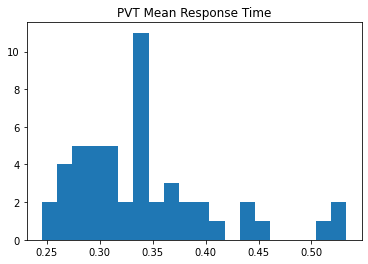

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(pvt_results['RT'][pvt_results['RT'] < 0.65], bins=20)
plt.title('PVT Mean Response Time')

Text(0.5, 1.0, 'PVT False Starts')

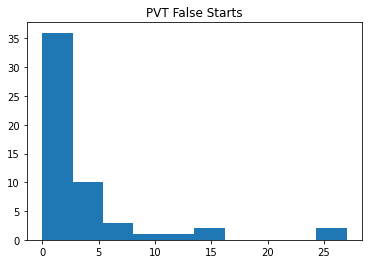

In [44]:
plt.hist(pvt_results['FS'], bins=10) #excluding 20127 as outlier
plt.title('PVT False Starts')

Text(0.5, 1.0, 'PVT No Responses')

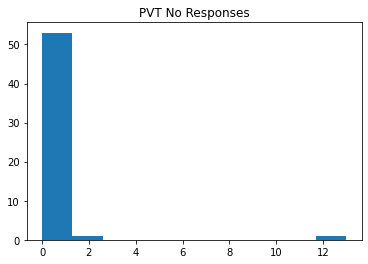

In [46]:
plt.hist(pvt_results['NR'], bins=10)
plt.title('PVT No Responses')